In [1]:
import pandas as pd
import pymc3 as pm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Inflation Data is taken from https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=IT-US-JP-GB
inflation_multi_country = pd.read_csv("./API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_10473735.csv")

In [4]:
def get_inflation_from_country(inflation_multi_country, country_name):
    inflation = inflation_multi_country[
        inflation_multi_country["Country Name"] == country_name
    ].drop(
        ["Country Name", "Country Code", "Indicator Name", "Indicator Code"], 
        axis=1
    ).transpose()
    inflation.columns = ["inflation"]
    inflation = inflation[~inflation.inflation.isnull()] 
    idx = np.arange(len(inflation))
    idx_to_year = {el[0]:el[1] for el in zip(idx, inflation.index)}
    return inflation, idx, idx_to_year

In [31]:
def fit_switchpoint_model(inflation, idx):
    inflation_data = inflation["inflation"].values
    n_inflation_data = len(inflation_data)
    
    with pm.Model() as model:
        sd_1 = pm.HalfCauchy("sd_1",1)
        sd_2 = pm.HalfCauchy("sd_2", 1)
    
        mu_1 = pm.Normal("mu_1", mu=0, sd=1e4)
        mu_2 = pm.Normal("mu_2", mu=0, sd=1e4)
    
        tau = pm.DiscreteUniform("tau", lower=0, upper=n_inflation_data - 1)
    
        sd_ = pm.math.switch(tau > idx, sd_1, sd_2)
        mu_ = pm.math.switch(tau > idx, mu_1, mu_2)
        observation = pm.Normal("obs", mu=mu_, sd=sd_, observed=inflation_data)
        trace = pm.sample(20000, tune=10000)
        
    ppc = pm.sample_posterior_predictive(trace, samples=10000, model=model)
    return trace, ppc

In [32]:
def format_ppc(ppc, idx_to_year):
    unrolled_ppc = pd.DataFrame(ppc["obs"]).unstack().reset_index().drop("level_1", axis=1)
    unrolled_ppc["year"] = unrolled_ppc.level_0.replace(idx_to_year).astype(int)
    unrolled_ppc = unrolled_ppc.rename(columns={0:"inflation"}).drop("level_0", axis=1)
    return unrolled_ppc

In [33]:
def plot_ppc(ax, ppc, idx_to_year, xticks, inflation, country_name):
    unrolled_ppc = format_ppc(ppc, idx_to_year)
    ax = sns.lineplot(
    x="year", y="inflation", 
    data=unrolled_ppc[unrolled_ppc.year.isin(xticks)], ax=ax, ci="sd", label="Model Inflation (Mean +/- SD)")
    # sns.kdeplot(years_trace, bw=0.5, ax=ax, shade=True)
    ax.plot((1992, 1992), (0, 22), color="r", label="Maastricht");
    ax.plot((1998, 1998), (0, 22), color="darkred", label="SEBC");
    ax.plot((1973, 1973), (0, 22), color="darkgreen", label="1st Oil Crisis");
    ax.plot((1979, 1979), (0, 22), color="darkgreen", label="2nd Oil Crisis");
    ax.grid()
    ax.set_ylim((0, 22))
    ax.set_xticks(xticks);
    ax.set_yticks(np.arange(0, 22, 2))
    ax.plot(xticks, inflation.loc[[str(xtick) for xtick in xticks]], label="Actual Inflation")
    # ax.plot(xticks, unrolled_ppc.groupby("year").std().loc[xticks], label="STD")
    
    ax.legend();

In [34]:
def plot_sp_kde(ax, trace, idx_to_year, xticks, country_name):
    years_trace = pd.Series(trace["tau"]).replace(idx_to_year).astype(int)
    sns.kdeplot(years_trace, bw=0.5, ax=ax, shade=True)
    ax.set_xticks(xticks);
    ax.grid()

In [35]:
def plot_results(ppc, trace, inflation, idx_to_year, country_name):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    ax = axs[0]
    xticks = np.arange(1960, 2016, 2)
    plot_ppc(ax, ppc, idx_to_year, xticks, inflation, country_name)
    ax.set_title("Inflation in {}".format(country_name))
    ax = axs[1]
    ax.set_title("When did inflation behaviour change in {}? Probability estimate for each year".format(country_name));
    plot_sp_kde(ax, trace, idx_to_year, xticks, country_name)
    return fig

In [36]:
inflation_it, idx_it, idx_to_year_it = get_inflation_from_country(inflation_multi_country, "Italy")
trace_it, ppc_it = fit_switchpoint_model(inflation_it, idx_it)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_2, mu_1, sd_2, sd_1]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:50<00:00, 1181.43draws/s]
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 10000/10000 [00:05<00:00, 1824.75it/s]


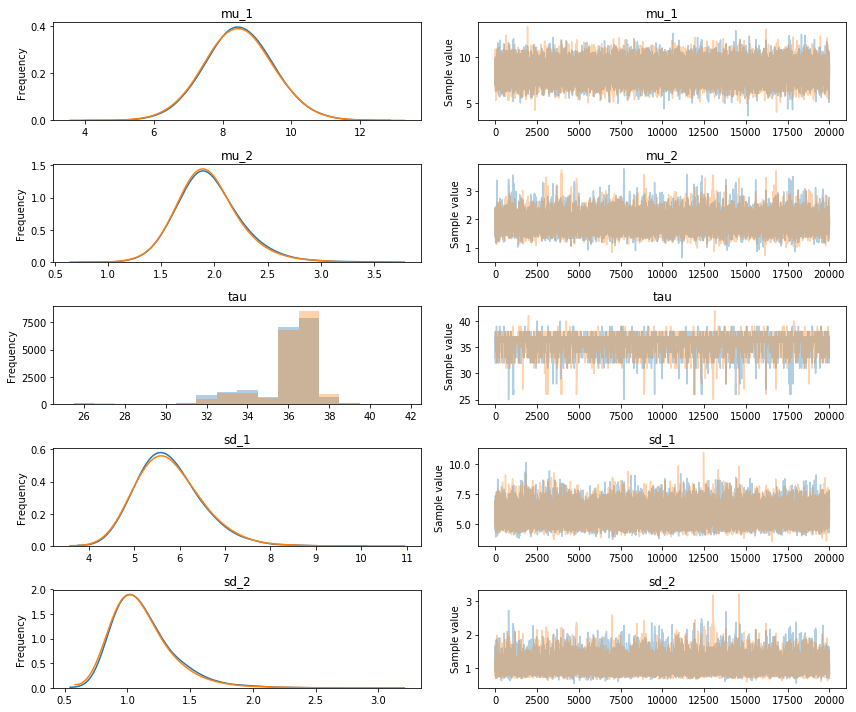

In [37]:
pm.traceplot(trace_it);

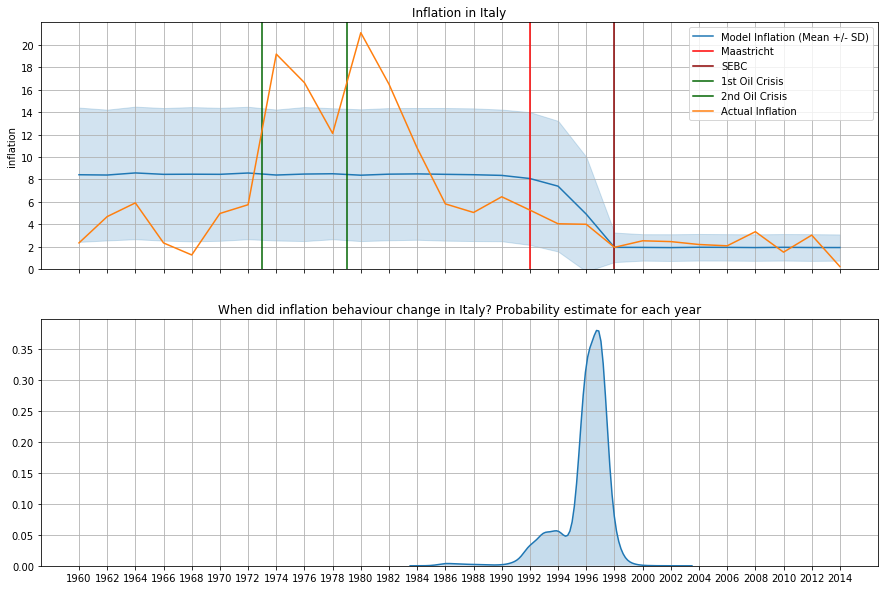

In [39]:
fig_it = plot_results(ppc_it, trace_it, inflation_it, idx_to_year_it, "Italy")

In [40]:
inflation_us, idx_us, idx_to_year_us = get_inflation_from_country(inflation_multi_country, "United States")
trace_us, ppc_us = fit_switchpoint_model(inflation_us, idx_us)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_2, mu_1, sd_2, sd_1]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:46<00:00, 1300.70draws/s]
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 10000/10000 [00:05<00:00, 1671.51it/s]


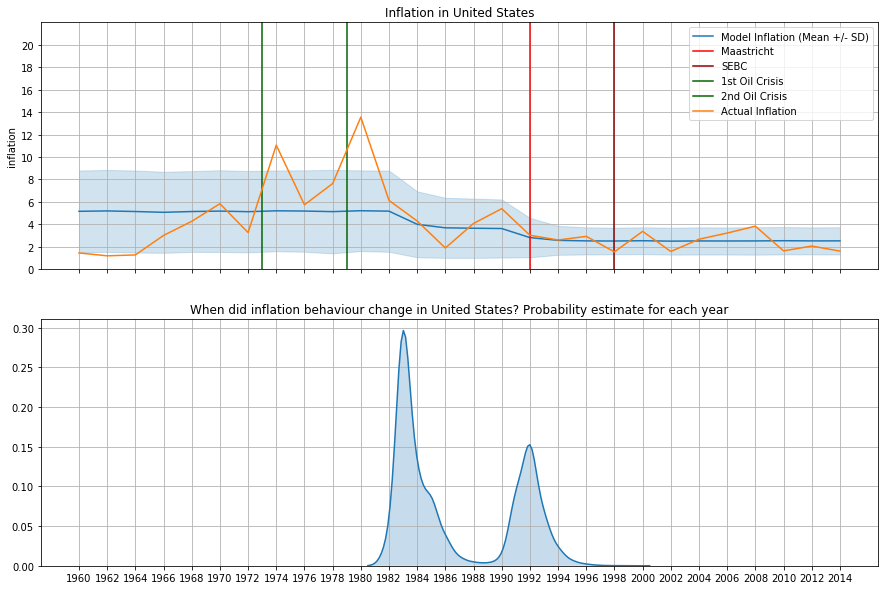

In [41]:
fig_us = plot_results(ppc_us, trace_us, inflation_us, idx_to_year_us, "United States")

In [42]:
inflation_jp, idx_jp, idx_to_year_jp = get_inflation_from_country(inflation_multi_country, "Japan")
trace_jp, ppc_jp = fit_switchpoint_model(inflation_jp, idx_jp)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_2, mu_1, sd_2, sd_1]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:45<00:00, 1322.01draws/s]
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 10000/10000 [00:06<00:00, 1606.58it/s]


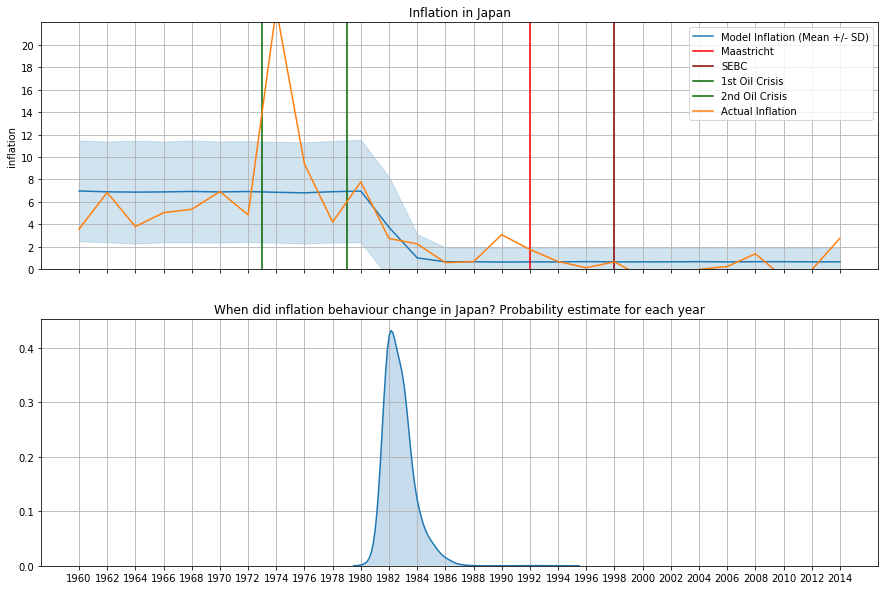

In [43]:
fig_us = plot_results(ppc_jp, trace_jp, inflation_jp, idx_to_year_jp, "Japan")

In [44]:
inflation_uk, idx_uk, idx_to_year_uk = get_inflation_from_country(inflation_multi_country, "United Kingdom")
trace_uk, ppc_uk = fit_switchpoint_model(inflation_uk, idx_uk)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu_2, mu_1, sd_2, sd_1]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:45<00:00, 1305.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 10000/10000 [00:05<00:00, 1690.35it/s]


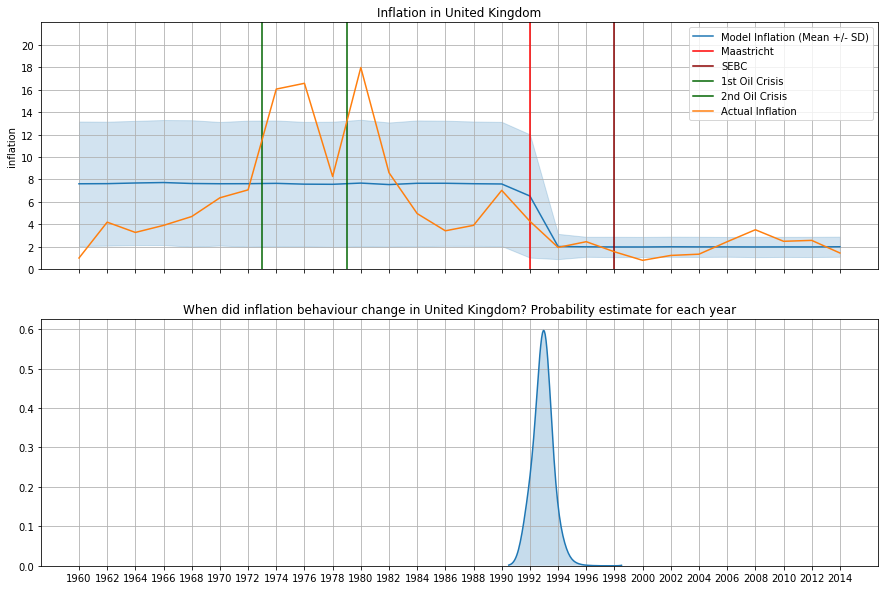

In [45]:
fig_us = plot_results(ppc_uk, trace_uk, inflation_uk, idx_to_year_uk, "United Kingdom")

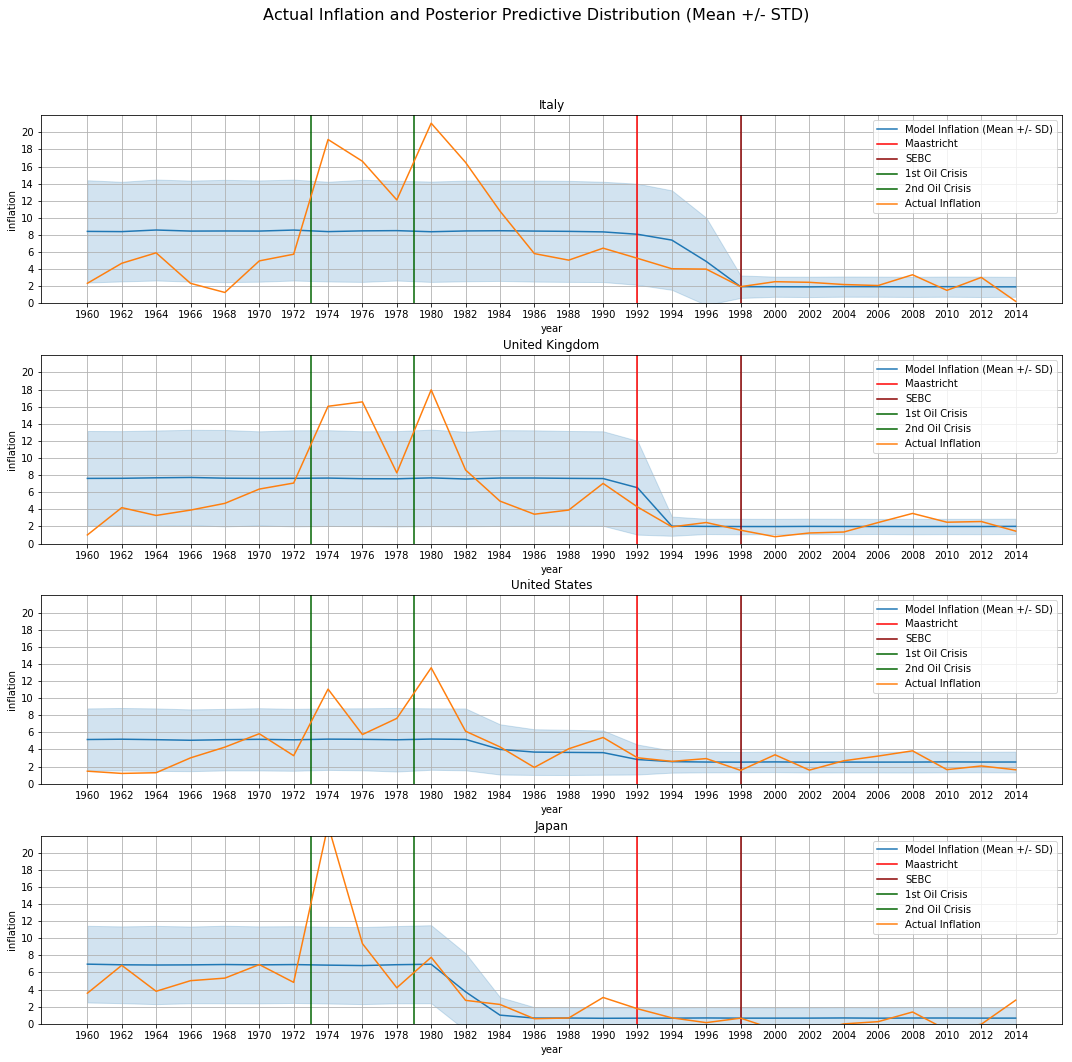

In [46]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.suptitle("Actual Inflation and Posterior Predictive Distribution (Mean +/- STD)", fontsize=16)


xticks = np.arange(1960, 2016, 2)
plot_ppc(axs[0], ppc_it, idx_to_year_it, xticks, inflation_it, "Italy")
plot_ppc(axs[1], ppc_uk, idx_to_year_uk, xticks, inflation_uk, "United Kingdom")
plot_ppc(axs[2], ppc_us, idx_to_year_us, xticks, inflation_us, "United States")
plot_ppc(axs[3], ppc_jp, idx_to_year_jp, xticks, inflation_jp, "Japan")
axs[0].set_title("Italy")
axs[1].set_title("United Kingdom")
axs[2].set_title("United States")
axs[3].set_title("Japan")
plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig('/home/alebu/Documents/ppc.png', bbox_inches='tight')

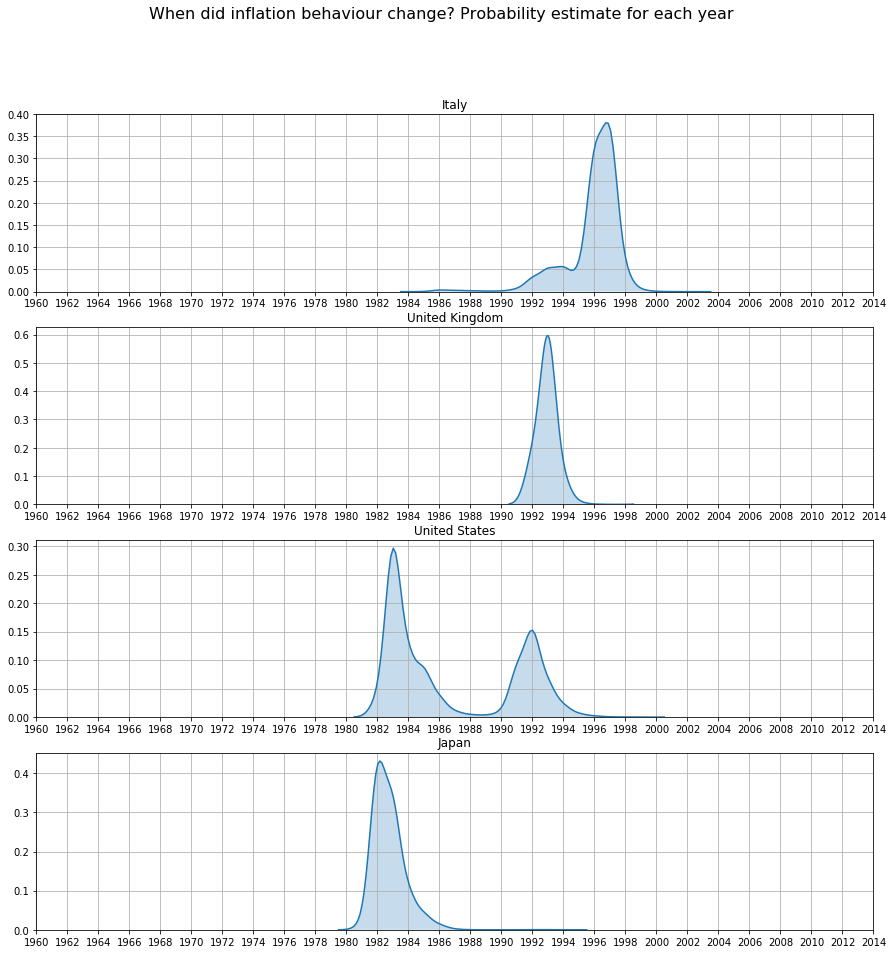

In [47]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.suptitle("When did inflation behaviour change? Probability estimate for each year", fontsize=16)
xticks = np.arange(1960, 2016, 2)
plot_sp_kde(axs[0], trace_it, idx_to_year_it, xticks, "Italy")
axs[0].set_title("Italy")
plot_sp_kde(axs[1], trace_uk, idx_to_year_uk, xticks, "United Kingdom")
axs[1].set_title("United Kingdom")
plot_sp_kde(axs[2], trace_us, idx_to_year_us, xticks, "United States")
axs[2].set_title("United States")
plot_sp_kde(axs[3], trace_jp, idx_to_year_jp, xticks, "Japan")
axs[3].set_title("Japan")
fig.savefig('/home/alebu/Documents/kde.png', bbox_inches='tight')